# Graph attention network

The graph attention network is our third GNN for semi-supervised node classification. As opposed to the four classical machine learning classifiers which serve as our baselines, it is capable of taking into account both the graph structure and the node features to predict the value of `segment` for a node.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import seaborn as sns

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

import ipynb
from ipynb.fs.defs.dataset_creation import NodeClassificationDataset

import json
import os
import os.path as osp
import time

from sklearn.manifold import TSNE

import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from torch_geometric.data import Dataset, download_url
from torch_geometric.transforms import NormalizeFeatures, RandomNodeSplit

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

In [2]:
def reverse(tuples):
    """
    Reverse a 2-tuple.
    """
    new_tup = tuples[::-1]
    
    return new_tup

In [3]:
def mean(dict_values):
    """
    Get mean of dictionary values.
    """
    return np.mean(np.array(list(dict_values)))

In [4]:
def std(dict_values):
    """
    Get standard deviation of dictionary values.
    """
    return np.std(np.array(list(dict_values)))

In [5]:
def filter_best_hyperparameters(df, variable):
    """
    Filter the results data frame for the best hyperparameter combination(s).
    """
    return df[df[variable] == df[variable].max()]

In [6]:
def print_best_hyperparameters(df, variable):
    """
    Print best hyperparameter combination(s).
    """
    df_best = df[df[variable] == df[variable].max()]
    print('The best hyperparameter combination/s is/are:\n\t',
          '\n\t '.join([str(df_best['parameters'].iloc[i]) for i in range(len(df_best))]),
          '\nThe resulting mean best validation accuracy is:', df_best[variable].unique()[0])

In [7]:
def model_summary(model): 
    """
    Get a summary of the neural network/graph neural network.
    """
    model_params_list = list(model.named_parameters())
    print("----------------------------------------------------------------")
    line_new = "{:>20}  {:>25} {:>15}".format("Layer.Parameter", "Param Tensor Shape", "Param #")
    print(line_new)
    print("----------------------------------------------------------------")
    for elem in model_params_list:
        p_name = elem[0] 
        p_shape = list(elem[1].size())
        p_count = torch.tensor(elem[1].size()).prod().item()
        line_new = "{:>20}  {:>25} {:>15}".format(p_name, str(p_shape), str(p_count))
        print(line_new)
    print("----------------------------------------------------------------")
    total_params = sum([param.nelement() for param in model.parameters()])
    print("Total params:", total_params)
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Trainable params:", num_trainable_params)
    print("Non-trainable params:", total_params - num_trainable_params)

In [8]:
def visualize(h, color):
    """
    Visualize the learned embeddings after reducing them to two dimensions.
    """
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    scatter = plt.scatter(z[:, 0], z[:, 1], s=10, c=color, cmap="Set2")
    handles, _ = scatter.legend_elements(prop='colors')
    handles = [handles[i] for i in [2,3,1,0]]
    labels = ['S1', 'S2', 'S3', 'S4']
    return handles, labels

In [9]:
def plot_embeddings(df, filename, save):
    """
    Plot the two-dimensional embeddings in a 5 times 2 plot.
    """
    torch_geometric.seed_everything(12345) 
    
    sns.set_style("whitegrid") 

    plt.figure(figsize=(8, 12))
    
    ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    out_mlp_1, out_mlp_2, out_mlp_3, out_mlp_4, out_mlp_5, out_mlp_6, out_mlp_7, out_mlp_8, out_mlp_9, out_mlp_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    y_1, y_2, y_3, y_4, y_5, y_6, y_7, y_8, y_9, y_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    
    seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]
    axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]
    out_mlp = [out_mlp_1, out_mlp_2, out_mlp_3, out_mlp_4, out_mlp_5, out_mlp_6, out_mlp_7, out_mlp_8, out_mlp_9, out_mlp_10]
    y = [y_1, y_2, y_3, y_4, y_5, y_6, y_7, y_8, y_9, y_10]
    for i, seed in enumerate(seeds):
        out_mlp[i] = df['embeddings'][i] 
        y[i] = df['y'][i] 
        axes[i] = plt.subplot(5,2,i+1)
        handles, labels = visualize(out_mlp[i], color=y[i])
        axes[i].set_title(f"Run {i+1}: seed {seed}")

    for ax in axes:
        ax.set(xlabel='Dimension 1', ylabel='Dimension 2')
        
    plt.tight_layout() 
        
    legend = plt.legend(handles, labels, ncol=4, loc='upper center', bbox_to_anchor=(-0.1, -0.3), frameon=True, title='segment',
                        edgecolor='black')

    if save:
        plt.savefig(f"./plots/{filename}.svg", bbox_inches='tight')

In [10]:
def plot_losses_and_accuracies(plot_type, df, index, spacing, filename, save):
    """
    Create the data frames required for plotting the losses and accuracies.
    """
    sns.set_style("whitegrid")
    
    epoch_1, epoch_2, epoch_3, epoch_4, epoch_5, epoch_6, epoch_7, epoch_8, epoch_9, epoch_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    epochs = [epoch_1, epoch_2, epoch_3, epoch_4, epoch_5, epoch_6, epoch_7, epoch_8, epoch_9, epoch_10]
    
    if plot_type == 'loss':
        loss_df_1, loss_df_2, loss_df_3, loss_df_4, loss_df_5, loss_df_6, loss_df_7, loss_df_8, loss_df_9, loss_df_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
        loss_df = [loss_df_1, loss_df_2, loss_df_3, loss_df_4, loss_df_5, loss_df_6, loss_df_7, loss_df_8, loss_df_9, loss_df_10]
        print_list = ['loss'] * 10
    elif plot_type == 'acc':
        acc_df_1, acc_df_2, acc_df_3, acc_df_4, acc_df_5, acc_df_6, acc_df_7, acc_df_8, acc_df_9, acc_df_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 
        acc_df = [acc_df_1, acc_df_2, acc_df_3, acc_df_4, acc_df_5, acc_df_6, acc_df_7, acc_df_8, acc_df_9, acc_df_10]
        print_list = ['acc'] * 10
    elif plot_type == 'ap':
        ap_df_1, ap_df_2, ap_df_3, ap_df_4, ap_df_5, ap_df_6, ap_df_7, ap_df_8, ap_df_9, ap_df_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 
        ap_df = [ap_df_1, ap_df_2, ap_df_3, ap_df_4, ap_df_5, ap_df_6, ap_df_7, ap_df_8, ap_df_9, ap_df_10]
        print_list = ['ap'] * 10
    elif plot_type == 'auc':
        auc_df_1, auc_df_2, auc_df_3, auc_df_4, auc_df_5, auc_df_6, auc_df_7, auc_df_8, auc_df_9, auc_df_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 
        auc_df = [auc_df_1, auc_df_2, auc_df_3, auc_df_4, auc_df_5, auc_df_6, auc_df_7, auc_df_8, auc_df_9, auc_df_10]
        print_list = ['auc'] * 10
    
    for i in range(len(epochs)):
        epochs[i] = [k for k in range(1, 1+len(df['train_losses'][index][f"{i+1}"]))]
    
        if plot_type == 'loss':
            loss_df[i] = pd.DataFrame(list(zip(epochs[i], df['train_losses'][index][f"{i+1}"], \
                                               df['val_losses'][index][f"{i+1}"], df['test_losses'][index][f"{i+1}"])), \
                                      columns = ['epoch', 'train_loss', 'val_loss', 'test_loss'])
            loss_df[i] = pd.melt(loss_df[i], id_vars=['epoch'], value_vars=['train_loss', 'val_loss', 'test_loss'])
        elif plot_type == 'acc':
            acc_df[i] = pd.DataFrame(list(zip(epochs[i], df['train_accs'][index][f"{i+1}"], \
                                              df['val_accs'][index][f"{i+1}"], df['test_accs'][index][f"{i+1}"])), \
                                     columns = ['epoch', 'train_acc', 'val_acc', 'test_acc'])
            acc_df[i] = pd.melt(acc_df[i], id_vars=['epoch'], value_vars=['train_acc', 'val_acc', 'test_acc'])
        elif plot_type == 'ap':
            ap_df[i] = pd.DataFrame(list(zip(epochs[i], df['train_aps'][index][f"{i+1}"], \
                                              df['val_aps'][index][f"{i+1}"], df['test_aps'][index][f"{i+1}"])), \
                                     columns = ['epoch', 'train_ap', 'val_ap', 'test_ap'])
            ap_df[i] = pd.melt(ap_df[i], id_vars=['epoch'], value_vars=['train_ap', 'val_ap', 'test_ap'])
        elif plot_type == 'auc':
            auc_df[i] = pd.DataFrame(list(zip(epochs[i], df['train_aucs'][index][f"{i+1}"], \
                                              df['val_aucs'][index][f"{i+1}"], df['test_aucs'][index][f"{i+1}"])), \
                                     columns = ['epoch', 'train_auc', 'val_auc', 'test_auc'])
            auc_df[i] = pd.melt(auc_df[i], id_vars=['epoch'], value_vars=['train_auc', 'val_auc', 'test_auc'])
        
    seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]
    
    fig1, fig2, fig3, fig4, fig5, fig6, fig7, fig8, fig9, fig10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    figs = [fig1, fig2, fig3, fig4, fig5, fig6, fig7, fig8, fig9, fig10]
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16,24))
    
    axes_list = [axes[0,0], axes[0,1], axes[1,0], axes[1,1], axes[2,0], axes[2,1], axes[3,0], axes[3,1], axes[4,0], axes[4,1]]
    
    for j, seed in enumerate(seeds):
        if plot_type == 'loss':
            data = loss_df[j]
        elif plot_type == 'acc':
            data = acc_df[j]
        elif plot_type == 'ap':
            data = ap_df[j]
        elif plot_type == 'auc':
            data = auc_df[j]
        figs[j] = sns.lineplot(data=data, x="epoch", y="value", hue="variable", ax=axes_list[j]).set_title(f"Run {j + 1} with seed {seeds[j]}: {print_list[j]}/epoch", fontsize=16)
        axes_list[j].xaxis.set_major_locator(MultipleLocator(spacing))
    
    plt.tight_layout()
        
    if save:
        plt.savefig(f"./plots/{filename}.svg", bbox_inches='tight') 

## Hyperparameter tuning

We use the [PyTorch Geometric implementation](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GATConv) of a graph attentional operator `GATConv`. 

With GATs, the main hyperparameters to tune are:
* `hidden_channels`: size of each hidden sample. It gives us the dimension of the embeddings in the hidden layer. 
* `heads`: number of multi-head attentions. 
* `dropout_prob`: probability of an element to be zeroed.
* `learning_rate`: learning rate of the Adam optimizer.
* `weight_decay`: weight decay (L2 penalty).
* `patience`: number of epochs after which to stop the training process if no improvement in the validation loss has been observed in the meantime.

There are still other hyperparameters that can be tuned, e.g., the optimizer and the depth of the GAT. We do not train them and instead rely on standard choices, e.g., Adam as optimizer. As far as the depth is concerned, we rely on an architecture with only one hidden layer to avoid overfitting, given our relatively samll number of 229 nodes. We now perform the hyperparameter tuning using loops.

In [11]:
# Create results folder
route0 = "./results"

if not os.path.exists(route0):
    os.mkdir(route0)

In [12]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads, dropout_prob):
        super().__init__()
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=heads, dropout=dropout_prob)
        self.conv2 = GATConv(heads * hidden_channels, dataset.num_classes, heads=heads, concat=False, dropout=dropout_prob)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=dropout_prob, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=dropout_prob, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=-1)
    
def train():
    model.train()
    optimizer.zero_grad()  
    out_train=model(data.x, data.edge_index)[data.train_mask]
    loss_train = criterion(out_train, data.y[data.train_mask])
    loss_train.backward()  
    optimizer.step() 
    model.eval()
    out_val = model(data.x, data.edge_index)[data.val_mask]
    loss_val = criterion(out_val, data.y[data.val_mask])
    out_test = model(data.x, data.edge_index)[data.test_mask]
    loss_test = criterion(out_test, data.y[data.test_mask])
    return loss_train, loss_val, loss_test, out_train, out_val, out_test


def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  
    train_correct = pred[data.train_mask] == data.y[data.train_mask]  
    val_correct = pred[data.val_mask] == data.y[data.val_mask] 
    test_correct = pred[data.test_mask] == data.y[data.test_mask] 
    train_acc = int(train_correct.sum()) / int(data.train_mask.sum())  
    val_acc = int(val_correct.sum()) / int(data.val_mask.sum()) 
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum()) 
    return train_acc, val_acc, test_acc 

In [ ]:
start_time = time.time()

gat_results = pd.DataFrame(columns = ['parameters', 'train_losses', 'val_losses', 'test_losses', 'train_accs', 'val_accs', 
                                      'test_accs', 'best_train_losses', 'best_val_losses', 'best_test_losses', 
                                      'best_train_accs', 'best_val_accs', 'best_test_accs', 'mean_best_train_loss', 
                                      'mean_best_val_loss', 'mean_best_test_loss', 'mean_best_train_acc', 'mean_best_val_acc', 
                                      'mean_best_test_acc', 'std_best_train_loss', 'std_best_val_loss', 'std_best_test_loss', 
                                      'std_best_train_acc', 'std_best_val_acc', 'std_best_test_acc'])

seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]

for hidden_channels in [8, 16, 32]:
    for heads in [1, 2]: 
        for dropout_prob in [0.1, 0.3, 0.5]: 
            for learning_rate in [0.001, 0.01, 0.1]:
                for weight_decay in [5e-1, 5e-2, 5e-3, 5e-4]: 
                    for patience in [5, 10]:

                        # Hyperparamter tuning

                        print(f'====================================================================================================\nParameter combination: {{hidden_channels: {hidden_channels}, heads: {heads}, dropout_prob: {dropout_prob}, learning_rate: {learning_rate}, weight_decay: {weight_decay}, patience: {patience}}}\n====================================================================================================')

                        parameter_dict = dict({'hidden_channels': hidden_channels, 'heads': heads, 'dropout_prob': dropout_prob, 'learning_rate': learning_rate, 'weight_decay': weight_decay, 'patience': patience})

                        loss_dict = dict() 
                        val_loss_dict = dict() 
                        test_loss_dict = dict() 
                        train_acc_dict = dict() 
                        val_acc_dict = dict() 
                        test_acc_dict = dict() 

                        best_train_loss_dict = dict()
                        best_val_loss_dict = dict()
                        best_test_loss_dict = dict()
                        best_train_acc_dict = dict()
                        best_val_acc_dict = dict()
                        best_test_acc_dict = dict()

                        for i, seed in enumerate(seeds): 

                            torch_geometric.seed_everything(seed) 

                            dataset = NodeClassificationDataset(root='data/', transform=RandomNodeSplit(split="random", num_train_per_class = 10, num_val = 60, num_test = 129))
                            data = dataset[0]
                            
                            model = GAT(hidden_channels = hidden_channels, heads = heads, dropout_prob = dropout_prob)

                            criterion = torch.nn.CrossEntropyLoss()  
                            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  

                            loss_list = []
                            val_loss_list = []
                            test_loss_list = []
                            train_acc_list = []
                            val_acc_list = []
                            test_acc_list = []

                            last_loss = 100
                            patience = patience 
                            trigger_times = 0

                            print(f'==================================================\nRun {i+1} with seed {seed}:\n==================================================')

                            for epoch in range(1, 101):
                                loss, val_loss, test_loss, out_train, out_val, out_test = train() 
                                train_acc, val_acc, test_acc = test() 
                                loss_list += [loss.item()]
                                val_loss_list += [val_loss.item()]
                                test_loss_list += [test_loss.item()]
                                train_acc_list += [train_acc]
                                val_acc_list += [val_acc]
                                test_acc_list += [test_acc]

                                current_val_loss = val_loss

                                print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}, train acc: {train_acc:.4f}, val acc: {val_acc:.4f}, test acc: {test_acc:.4f}')

                                if current_val_loss <= last_loss:
                                    current_best_train_loss = loss.item()
                                    current_best_val_loss = current_val_loss.item()
                                    current_best_test_loss = test_loss.item()
                                    current_best_train_acc = train_acc
                                    current_best_val_acc = val_acc
                                    current_best_test_acc = test_acc

                                    trigger_times = 0
                                    print('Trigger times: 0')

                                    last_loss = current_val_loss

                                else: 
                                    trigger_times += 1
                                    print('Trigger times:', trigger_times)

                                    if trigger_times >= patience:
                                        print('Early stopping!')
                                        break

                            loss_dict.update({f"{i+1}": loss_list}) 
                            val_loss_dict.update({f"{i+1}": val_loss_list}) 
                            test_loss_dict.update({f"{i+1}": test_loss_list})
                            train_acc_dict.update({f"{i+1}": train_acc_list}) 
                            val_acc_dict.update({f"{i+1}": val_acc_list})
                            test_acc_dict.update({f"{i+1}": test_acc_list}) 

                            best_train_loss_dict.update({f"{i+1}": current_best_train_loss}) 
                            best_val_loss_dict.update({f"{i+1}": current_best_val_loss}) 
                            best_test_loss_dict.update({f"{i+1}": current_best_test_loss}) 
                            best_train_acc_dict.update({f"{i+1}": current_best_train_acc}) 
                            best_val_acc_dict.update({f"{i+1}": current_best_val_acc}) 
                            best_test_acc_dict.update({f"{i+1}": current_best_test_acc}) 

                            print(current_best_val_loss)

                        data_concat = [{'parameters': parameter_dict, 'train_losses': loss_dict, 'val_losses': val_loss_dict, 
                                        'test_losses': test_loss_dict, 'train_accs': train_acc_dict, 'val_accs': val_acc_dict, 
                                        'test_accs': test_acc_dict, 'best_train_losses': best_train_loss_dict, 
                                        'best_val_losses': best_val_loss_dict, 'best_test_losses': best_test_loss_dict, 
                                        'best_train_accs': best_train_acc_dict, 'best_val_accs': best_val_acc_dict, 
                                        'best_test_accs': best_test_acc_dict, 
                                        'mean_best_train_loss': mean(best_train_loss_dict.values()), 
                                        'mean_best_val_loss': mean(best_val_loss_dict.values()), 
                                        'mean_best_test_loss': mean(best_test_loss_dict.values()), 
                                        'mean_best_train_acc': mean(best_train_acc_dict.values()), 
                                        'mean_best_val_acc': mean(best_val_acc_dict.values()), 
                                        'mean_best_test_acc': mean(best_test_acc_dict.values()),
                                        'std_best_train_loss': std(best_train_loss_dict.values()), 
                                        'std_best_val_loss': std(best_val_loss_dict.values()), 
                                        'std_best_test_loss': std(best_test_loss_dict.values()), 
                                        'std_best_train_acc': std(best_train_acc_dict.values()), 
                                        'std_best_val_acc': std(best_val_acc_dict.values()), 
                                        'std_best_test_acc': std(best_test_acc_dict.values())}]
                        df_concat = pd.DataFrame(data_concat)
                        gat_results = pd.concat([gat_results, df_concat], ignore_index=True)
                    
print('====================================================================================================',
      '\n====================================================================================================', 
      '\n====================================================================================================')

print("saving file corresponding to gat_results.pkl")
gat_results.to_pickle(f"{route0}/gat_results.pkl")

end_time = time.time()
duration = end_time - start_time
print(f"{int(np.floor(duration/3600))} hours {(duration-3600*np.floor(duration/3600))/60:.4} minutes")

In [13]:
# Look at results
gat_results = pd.read_pickle(f"{route0}/gat_results.pkl") 
gat_results

,parameters,train_losses,val_losses,test_losses,train_accs,val_accs,test_accs,best_train_losses,best_val_losses,best_test_losses,...,mean_best_test_loss,mean_best_train_acc,mean_best_val_acc,mean_best_test_acc,std_best_train_loss,std_best_val_loss,std_best_test_loss,std_best_train_acc,std_best_val_acc,std_best_test_acc
0,"{'hidden_channels': 8, 'heads': 1, 'dropout_pr...","{'1': [1.4344816207885742, 1.4366010427474976,...","{'1': [1.4816535711288452, 1.4785324335098267,...","{'1': [1.4626401662826538, 1.459993600845337, ...","{'1': [0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.3...","{'1': [0.2833333333333333, 0.2833333333333333,...","{'1': [0.3488372093023256, 0.3488372093023256,...","{'1': 1.3906140327453613, '2': 1.4112656116485...","{'1': 1.41020929813385, '2': 1.289461374282837...","{'1': 1.4002493619918823, '2': 1.2744526863098...",...,1.387690,0.2900,0.256667,0.242636,0.039148,0.040370,0.048015,0.043589,0.113088,0.092897
1,"{'hidden_channels': 8, 'heads': 1, 'dropout_pr...","{'1': [1.4344816207885742, 1.4366010427474976,...","{'1': [1.4816535711288452, 1.4785324335098267,...","{'1': [1.4626401662826538, 1.459993600845337, ...","{'1': [0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.3...","{'1': [0.2833333333333333, 0.2833333333333333,...","{'1': [0.3488372093023256, 0.3488372093023256,...","{'1': 1.3906140327453613, '2': 1.4112656116485...","{'1': 1.4102091789245605, '2': 1.2894613742828...","{'1': 1.4002493619918823, '2': 1.2744526863098...",...,1.387690,0.2900,0.256667,0.242636,0.039148,0.040370,0.048015,0.043589,0.113088,0.092897
2,"{'hidden_channels': 8, 'heads': 1, 'dropout_pr...","{'1': [1.4344816207885742, 1.4344080686569214,...","{'1': [1.47700834274292, 1.469443917274475, 1....","{'1': [1.4587968587875366, 1.4524277448654175,...","{'1': [0.35, 0.325, 0.325, 0.3, 0.3, 0.3, 0.3,...","{'1': [0.2833333333333333, 0.2833333333333333,...","{'1': [0.3488372093023256, 0.34108527131782945...","{'1': 1.3896366357803345, '2': 1.4112656116485...","{'1': 1.3828294277191162, '2': 1.2912482023239...","{'1': 1.380477786064148, '2': 1.27683222293853...",...,1.380486,0.3000,0.275000,0.247287,0.044353,0.035783,0.044763,0.037081,0.122531,0.105975
3,"{'hidden_channels': 8, 'heads': 1, 'dropout_pr...","{'1': [1.4344816207885742, 1.4344080686569214,...","{'1': [1.47700834274292, 1.469443917274475, 1....","{'1': [1.4587968587875366, 1.4524277448654175,...","{'1': [0.35, 0.325, 0.325, 0.3, 0.3, 0.3, 0.3,...","{'1': [0.2833333333333333, 0.2833333333333333,...","{'1': [0.3488372093023256, 0.34108527131782945...","{'1': 1.3896366357803345, '2': 1.4112656116485...","{'1': 1.3828294277191162, '2': 1.2912482023239...","{'1': 1.380477786064148, '2': 1.27683222293853...",...,1.379517,0.3000,0.276667,0.249612,0.044360,0.035075,0.044272,0.037081,0.120231,0.103296
4,"{'hidden_channels': 8, 'heads': 1, 'dropout_pr...","{'1': [1.4344816207885742, 1.4334608316421509,...","{'1': [1.4759804010391235, 1.4675277471542358,...","{'1': [1.4579044580459595, 1.4507635831832886,...","{'1': [0.35, 0.325, 0.3, 0.3, 0.275, 0.3, 0.32...","{'1': [0.2833333333333333, 0.2833333333333333,...","{'1': [0.34108527131782945, 0.3255813953488372...","{'1': 1.3792476654052734, '2': 1.4112656116485...","{'1': 1.3826847076416016, '2': 1.2916796207427...","{'1': 1.3807024955749512, '2': 1.2774193286895...",...,1.383171,0.2975,0.278333,0.248837,0.043819,0.036508,0.045136,0.042500,0.134588,0.103101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,"{'hidden_channels': 32, 'heads': 2, 'dropout_p...","{'1': [1.4166067838668823, 2.0535695552825928,...","{'1': [1.4707353115081787, 2.4215152263641357,...","{'1': [1.8658616542816162, 2.1151771545410156,...","{'1': [0.25, 0.25, 0.25, 0.25, 0.25, 0.275, 0....","{'1': [0.36666666666666664, 0.0, 0.46666666666...","{'1': [0.26356589147286824, 0.0542635658914728...","{'1': 1.4872887134552002, '2': 1.3888068199157...","{'1': 1.1835472583770752, '2': 1.3012471199035...","{'1': 1.3007392883300781, '2': 1.2868006229400..

## Best hyperparameter combination

In [14]:
filter_best_hyperparameters(gat_results, 'mean_best_val_acc')

,parameters,train_losses,val_losses,test_losses,train_accs,val_accs,test_accs,best_train_losses,best_val_losses,best_test_losses,...,mean_best_test_loss,mean_best_train_acc,mean_best_val_acc,mean_best_test_acc,std_best_train_loss,std_best_val_loss,std_best_test_loss,std_best_train_acc,std_best_val_acc,std_best_test_acc
47,"{'hidden_channels': 8, 'heads': 1, 'dropout_pr...","{'1': [1.4678699970245361, 1.6431289911270142,...","{'1': [1.6457196474075317, 1.3326061964035034,...","{'1': [1.771454095840454, 1.4184097051620483, ...","{'1': [0.275, 0.25, 0.325, 0.25, 0.45, 0.375, ...","{'1': [0.08333333333333333, 0.4666666666666667...","{'1': [0.12403100775193798, 0.4263565891472868...","{'1': 1.513989806175232, '2': 1.21979117393493...","{'1': 1.229586124420166, '2': 1.24556839466094...","{'1': 1.272019863128662, '2': 1.31323719024658...",...,1.28997,0.395,0.46,0.435659,0.27216,0.0799,0.063941,0.067823,0.082057,0.081362


In [15]:
print_best_hyperparameters(gat_results, 'mean_best_val_acc')

The best hyperparameter combination/s is/are:
	 {'hidden_channels': 8, 'heads': 1, 'dropout_prob': 0.3, 'learning_rate': 0.1, 'weight_decay': 0.0005, 'patience': 10} 
The resulting validation accuracy is: 0.4600000000000001


## Visualizations

In [16]:
# Repeat 10 runs of best model

start_time = time.time()

gat_embeddings = pd.DataFrame(columns=['run', 'embeddings', 'y'])

seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]

# Best hyperparameters
hidden_channels = 8 #32
heads = 1 #1
dropout_prob = 0.3 #0.1
learning_rate = 0.1 #0.1
weight_decay = 5e-4 #5e-2
patience = 10 #10
                    
print(f'====================================================================================================\nParameter combination: {{hidden_channels: {hidden_channels}, heads: {heads}, dropout_prob: {dropout_prob}, learning_rate: {learning_rate}, weight_decay: {weight_decay}, patience: {patience}}}\n====================================================================================================')

parameter_dict = dict({'hidden_channels': hidden_channels, 'heads': heads, 'dropout_prob': dropout_prob, 'learning_rate': learning_rate, 'weight_decay': weight_decay, 'patience': patience})

for i, seed in enumerate(seeds): 

    torch_geometric.seed_everything(seed) 

    dataset = NodeClassificationDataset(root='data/', transform=RandomNodeSplit(split="random", num_train_per_class = 10, num_val = 60, num_test = 129))
    data = dataset[0]
    
    model = GAT(hidden_channels=hidden_channels, heads=heads, dropout_prob=dropout_prob)

    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) 

    last_loss = 100
    patience = patience 
    trigger_times = 0

    print(f'==================================================\nRun {i+1} with seed {seed}:\n==================================================')

    for epoch in range(1, 101):
        loss, val_loss, test_loss, out_train, out_val, out_test = train() 
        train_acc, val_acc, test_acc = test() 

        current_val_loss = val_loss

        print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}, train acc: {train_acc:.4f}, val acc: {val_acc:.4f}, test acc: {test_acc:.4f}')

        if current_val_loss <= last_loss:
            current_best_train_loss = loss.item()
            current_best_val_loss = current_val_loss.item()
            current_best_test_loss = test_loss.item()
            current_best_out_train = out_train
            current_best_out_val = out_val
            current_best_out_test = out_test
            current_best_train_acc = train_acc
            current_best_val_acc = val_acc
            current_best_test_acc = test_acc
            
            trigger_times = 0
            print('Trigger times: 0')
            
            last_loss = current_val_loss

        else: 
            trigger_times += 1
            print('Trigger times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!')
                break

    print(current_best_val_loss)
    
    embed = [{'run': i+1, 'embeddings': torch.cat((current_best_out_train, current_best_out_val, current_best_out_test), 0), 'y': data.y}]
    embed = pd.DataFrame(embed)
    gat_embeddings = pd.concat([gat_embeddings, embed], ignore_index=True)
                    
print('====================================================================================================',
      '\n====================================================================================================', 
      '\n====================================================================================================')

print("saving file corresponding to gat_embeddings.pkl")
gat_embeddings.to_pickle(f"{route0}/gat_embeddings.pkl")

end_time = time.time()
duration = end_time - start_time
print(f"{int(np.floor(duration/3600))} hours {(duration-3600*np.floor(duration/3600))/60:.4} minutes")

Parameter combination: {hidden_channels: 8, heads: 1, dropout_prob: 0.3, learning_rate: 0.1, weight_decay: 0.0005, patience: 10}
Run 1 with seed 12345:


Processing...
Done!


Epoch: 001, Train Loss: 1.4679, Val Loss: 1.6457, Test Loss: 1.7715, train acc: 0.2750, val acc: 0.0833, test acc: 0.1240
Trigger times: 0
Epoch: 002, Train Loss: 1.6431, Val Loss: 1.3326, Test Loss: 1.4184, train acc: 0.2500, val acc: 0.4667, test acc: 0.4264
Trigger times: 0
Epoch: 003, Train Loss: 1.5140, Val Loss: 1.2296, Test Loss: 1.2720, train acc: 0.3250, val acc: 0.5167, test acc: 0.4264
Trigger times: 0
Epoch: 004, Train Loss: 1.4622, Val Loss: 1.3833, Test Loss: 1.4661, train acc: 0.2500, val acc: 0.3667, test acc: 0.2636
Trigger times: 1
Epoch: 005, Train Loss: 1.3745, Val Loss: 1.5506, Test Loss: 1.5757, train acc: 0.4500, val acc: 0.1833, test acc: 0.2171
Trigger times: 2
Epoch: 006, Train Loss: 1.3706, Val Loss: 1.6373, Test Loss: 1.5984, train acc: 0.3750, val acc: 0.1167, test acc: 0.1395
Trigger times: 3
Epoch: 007, Train Loss: 1.2701, Val Loss: 1.4004, Test Loss: 1.4116, train acc: 0.5250, val acc: 0.1500, test acc: 0.1550
Trigger times: 4
Epoch: 008, Train Loss: 1.2

Processing...
Done!


Run 2 with seed 23456:
Epoch: 001, Train Loss: 1.3922, Val Loss: 2.8725, Test Loss: 2.8894, train acc: 0.2500, val acc: 0.0667, test acc: 0.0155
Trigger times: 0
Epoch: 002, Train Loss: 2.2806, Val Loss: 1.6638, Test Loss: 1.6683, train acc: 0.3000, val acc: 0.0667, test acc: 0.0388
Trigger times: 0
Epoch: 003, Train Loss: 1.4172, Val Loss: 1.2870, Test Loss: 1.3114, train acc: 0.5000, val acc: 0.5167, test acc: 0.4341
Trigger times: 0
Epoch: 004, Train Loss: 1.3266, Val Loss: 1.2726, Test Loss: 1.3021, train acc: 0.4250, val acc: 0.3000, test acc: 0.2868
Trigger times: 0
Epoch: 005, Train Loss: 1.3074, Val Loss: 1.2983, Test Loss: 1.3803, train acc: 0.3500, val acc: 0.5500, test acc: 0.3566
Trigger times: 1
Epoch: 006, Train Loss: 1.3659, Val Loss: 1.4540, Test Loss: 1.7047, train acc: 0.3500, val acc: 0.4833, test acc: 0.3333
Trigger times: 2
Epoch: 007, Train Loss: 1.2830, Val Loss: 1.7122, Test Loss: 1.9997, train acc: 0.4500, val acc: 0.1333, test acc: 0.0698
Trigger times: 3
Epoc

Processing...
Done!


Run 3 with seed 34567:
Epoch: 001, Train Loss: 1.4322, Val Loss: 1.7084, Test Loss: 2.0727, train acc: 0.2500, val acc: 0.2667, test acc: 0.2171
Trigger times: 0
Epoch: 002, Train Loss: 2.6626, Val Loss: 1.4286, Test Loss: 1.6271, train acc: 0.2500, val acc: 0.4667, test acc: 0.4264
Trigger times: 0
Epoch: 003, Train Loss: 1.9032, Val Loss: 1.3397, Test Loss: 1.3627, train acc: 0.2500, val acc: 0.4667, test acc: 0.4264
Trigger times: 0
Epoch: 004, Train Loss: 1.4197, Val Loss: 1.5154, Test Loss: 1.4260, train acc: 0.2500, val acc: 0.1833, test acc: 0.3411
Trigger times: 1
Epoch: 005, Train Loss: 1.4185, Val Loss: 1.5754, Test Loss: 1.4929, train acc: 0.2500, val acc: 0.2167, test acc: 0.3256
Trigger times: 2
Epoch: 006, Train Loss: 1.4481, Val Loss: 1.5471, Test Loss: 1.5713, train acc: 0.3000, val acc: 0.2833, test acc: 0.2713
Trigger times: 3
Epoch: 007, Train Loss: 1.3706, Val Loss: 1.4992, Test Loss: 1.5687, train acc: 0.3250, val acc: 0.3000, test acc: 0.2636
Trigger times: 4
Epoc

Processing...
Done!


Trigger times: 0
Epoch: 002, Train Loss: 2.3203, Val Loss: 1.4672, Test Loss: 1.6381, train acc: 0.3750, val acc: 0.4500, test acc: 0.3643
Trigger times: 0
Epoch: 003, Train Loss: 1.4640, Val Loss: 1.3953, Test Loss: 1.3383, train acc: 0.4500, val acc: 0.2000, test acc: 0.3178
Trigger times: 0
Epoch: 004, Train Loss: 1.3354, Val Loss: 1.5522, Test Loss: 1.4288, train acc: 0.4500, val acc: 0.3333, test acc: 0.3566
Trigger times: 1
Epoch: 005, Train Loss: 1.4630, Val Loss: 1.4217, Test Loss: 1.3483, train acc: 0.4750, val acc: 0.3500, test acc: 0.3566
Trigger times: 2
Epoch: 006, Train Loss: 1.3380, Val Loss: 1.2689, Test Loss: 1.2827, train acc: 0.5500, val acc: 0.3833, test acc: 0.3721
Trigger times: 0
Epoch: 007, Train Loss: 1.2558, Val Loss: 1.2340, Test Loss: 1.3230, train acc: 0.4750, val acc: 0.5667, test acc: 0.4341
Trigger times: 0
Epoch: 008, Train Loss: 1.2393, Val Loss: 1.2484, Test Loss: 1.4143, train acc: 0.4250, val acc: 0.5000, test acc: 0.4341
Trigger times: 1
Epoch: 009

Processing...
Done!


Run 5 with seed 56789:
Epoch: 001, Train Loss: 1.3744, Val Loss: 1.7115, Test Loss: 1.5086, train acc: 0.2750, val acc: 0.3167, test acc: 0.3101
Trigger times: 0
Epoch: 002, Train Loss: 2.0230, Val Loss: 1.1694, Test Loss: 1.1511, train acc: 0.4250, val acc: 0.4500, test acc: 0.4884
Trigger times: 0
Epoch: 003, Train Loss: 1.4484, Val Loss: 1.4488, Test Loss: 1.4753, train acc: 0.3250, val acc: 0.2667, test acc: 0.2481
Trigger times: 1
Epoch: 004, Train Loss: 1.3808, Val Loss: 1.6986, Test Loss: 1.6605, train acc: 0.2500, val acc: 0.0167, test acc: 0.0388
Trigger times: 2
Epoch: 005, Train Loss: 1.4171, Val Loss: 1.6943, Test Loss: 1.6440, train acc: 0.2750, val acc: 0.0333, test acc: 0.0543
Trigger times: 3
Epoch: 006, Train Loss: 1.3996, Val Loss: 1.5234, Test Loss: 1.4850, train acc: 0.2500, val acc: 0.2167, test acc: 0.2558
Trigger times: 4
Epoch: 007, Train Loss: 1.3746, Val Loss: 1.3414, Test Loss: 1.3258, train acc: 0.3750, val acc: 0.2667, test acc: 0.2946
Trigger times: 5
Epoc

Processing...
Done!


Epoch: 001, Train Loss: 1.3930, Val Loss: 1.6885, Test Loss: 1.8396, train acc: 0.2500, val acc: 0.2667, test acc: 0.2171
Trigger times: 0
Epoch: 002, Train Loss: 1.5624, Val Loss: 2.0131, Test Loss: 2.0993, train acc: 0.2500, val acc: 0.0500, test acc: 0.0233
Trigger times: 1
Epoch: 003, Train Loss: 1.5548, Val Loss: 1.4742, Test Loss: 1.4900, train acc: 0.3500, val acc: 0.0833, test acc: 0.0620
Trigger times: 0
Epoch: 004, Train Loss: 1.3122, Val Loss: 1.2589, Test Loss: 1.2257, train acc: 0.3000, val acc: 0.4000, test acc: 0.4496
Trigger times: 0
Epoch: 005, Train Loss: 1.4156, Val Loss: 1.2519, Test Loss: 1.2082, train acc: 0.3750, val acc: 0.4167, test acc: 0.4806
Trigger times: 0
Epoch: 006, Train Loss: 1.3408, Val Loss: 1.3265, Test Loss: 1.2976, train acc: 0.4000, val acc: 0.4167, test acc: 0.4651
Trigger times: 1
Epoch: 007, Train Loss: 1.2716, Val Loss: 1.4760, Test Loss: 1.4866, train acc: 0.4750, val acc: 0.1000, test acc: 0.1240
Trigger times: 2
Epoch: 008, Train Loss: 1.2

Processing...
Done!


Epoch: 001, Train Loss: 1.6522, Val Loss: 1.8181, Test Loss: 1.8557, train acc: 0.2500, val acc: 0.4333, test acc: 0.4264
Trigger times: 0
Epoch: 002, Train Loss: 1.6668, Val Loss: 1.8461, Test Loss: 1.8210, train acc: 0.2500, val acc: 0.2000, test acc: 0.2481
Trigger times: 1
Epoch: 003, Train Loss: 1.5775, Val Loss: 1.6028, Test Loss: 1.5848, train acc: 0.3000, val acc: 0.2167, test acc: 0.2326
Trigger times: 0
Epoch: 004, Train Loss: 1.3679, Val Loss: 1.4275, Test Loss: 1.4148, train acc: 0.2750, val acc: 0.2500, test acc: 0.2636
Trigger times: 0
Epoch: 005, Train Loss: 1.3809, Val Loss: 1.3240, Test Loss: 1.3351, train acc: 0.4000, val acc: 0.4833, test acc: 0.5271
Trigger times: 0
Epoch: 006, Train Loss: 1.3483, Val Loss: 1.3355, Test Loss: 1.3911, train acc: 0.3500, val acc: 0.4833, test acc: 0.4729
Trigger times: 1
Epoch: 007, Train Loss: 1.3688, Val Loss: 1.3621, Test Loss: 1.4216, train acc: 0.3500, val acc: 0.4833, test acc: 0.4729
Trigger times: 2
Epoch: 008, Train Loss: 1.3

Processing...
Done!


Run 8 with seed 76543:
Epoch: 001, Train Loss: 1.6136, Val Loss: 2.4560, Test Loss: 2.4164, train acc: 0.2500, val acc: 0.0167, test acc: 0.0388
Trigger times: 0
Epoch: 002, Train Loss: 1.8176, Val Loss: 1.5698, Test Loss: 1.5805, train acc: 0.2750, val acc: 0.4833, test acc: 0.4419
Trigger times: 0
Epoch: 003, Train Loss: 1.7595, Val Loss: 1.4705, Test Loss: 1.4622, train acc: 0.4500, val acc: 0.4167, test acc: 0.5271
Trigger times: 0
Epoch: 004, Train Loss: 1.5081, Val Loss: 1.5550, Test Loss: 1.5252, train acc: 0.4000, val acc: 0.1000, test acc: 0.1318
Trigger times: 1
Epoch: 005, Train Loss: 1.3065, Val Loss: 1.6348, Test Loss: 1.5976, train acc: 0.3750, val acc: 0.0667, test acc: 0.0775
Trigger times: 2
Epoch: 006, Train Loss: 1.2503, Val Loss: 1.7134, Test Loss: 1.6744, train acc: 0.3500, val acc: 0.2667, test acc: 0.2558
Trigger times: 3
Epoch: 007, Train Loss: 1.3636, Val Loss: 1.7050, Test Loss: 1.6614, train acc: 0.3500, val acc: 0.2667, test acc: 0.2558
Trigger times: 4
Epoc

Processing...
Done!


Epoch: 001, Train Loss: 1.5215, Val Loss: 2.3637, Test Loss: 2.2152, train acc: 0.2500, val acc: 0.0167, test acc: 0.0388
Trigger times: 0
Epoch: 002, Train Loss: 1.9560, Val Loss: 1.7772, Test Loss: 1.6434, train acc: 0.2500, val acc: 0.0167, test acc: 0.0388
Trigger times: 0
Epoch: 003, Train Loss: 1.6308, Val Loss: 1.3895, Test Loss: 1.3364, train acc: 0.3250, val acc: 0.4000, test acc: 0.4806
Trigger times: 0
Epoch: 004, Train Loss: 1.3965, Val Loss: 1.2398, Test Loss: 1.2768, train acc: 0.3750, val acc: 0.4667, test acc: 0.4806
Trigger times: 0
Epoch: 005, Train Loss: 1.3620, Val Loss: 1.2301, Test Loss: 1.3280, train acc: 0.3750, val acc: 0.4167, test acc: 0.2403
Trigger times: 0
Epoch: 006, Train Loss: 1.3746, Val Loss: 1.2777, Test Loss: 1.3967, train acc: 0.3250, val acc: 0.4000, test acc: 0.2326
Trigger times: 1
Epoch: 007, Train Loss: 1.3525, Val Loss: 1.2871, Test Loss: 1.4053, train acc: 0.3750, val acc: 0.4667, test acc: 0.2713
Trigger times: 2
Epoch: 008, Train Loss: 1.2

Processing...
Done!


Run 10 with seed 98765:
Epoch: 001, Train Loss: 1.4114, Val Loss: 1.7590, Test Loss: 1.7293, train acc: 0.2750, val acc: 0.3667, test acc: 0.4884
Trigger times: 0
Epoch: 002, Train Loss: 1.9461, Val Loss: 1.5934, Test Loss: 1.6428, train acc: 0.4250, val acc: 0.1500, test acc: 0.1240
Trigger times: 0
Epoch: 003, Train Loss: 1.5066, Val Loss: 1.4215, Test Loss: 1.4935, train acc: 0.2500, val acc: 0.4000, test acc: 0.2481
Trigger times: 0
Epoch: 004, Train Loss: 1.3753, Val Loss: 1.5284, Test Loss: 1.5133, train acc: 0.2750, val acc: 0.2333, test acc: 0.2558
Trigger times: 1
Epoch: 005, Train Loss: 1.3825, Val Loss: 1.6962, Test Loss: 1.5493, train acc: 0.3000, val acc: 0.1667, test acc: 0.2481
Trigger times: 2
Epoch: 006, Train Loss: 1.3520, Val Loss: 1.7764, Test Loss: 1.5416, train acc: 0.3250, val acc: 0.0500, test acc: 0.0698
Trigger times: 3
Epoch: 007, Train Loss: 1.3699, Val Loss: 1.4881, Test Loss: 1.3214, train acc: 0.4750, val acc: 0.1833, test acc: 0.2558
Trigger times: 4
Epo

In [17]:
# Look at embeddings
gat_embeddings = pd.read_pickle(f"{route0}/gat_embeddings.pkl") 
gat_embeddings

,run,embeddings,y
0,1,"[[tensor(-1.3994, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
1,2,"[[tensor(-1.5442, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
2,3,"[[tensor(-2.0571, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
3,4,"[[tensor(-2.0587, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
4,5,"[[tensor(-3.0484, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
5,6,"[[tensor(-2.4751, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
6,7,"[[tensor(-1.1750, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
7,8,"[[tensor(-1.1706, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
8,9,"[[tensor(-1.9142, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
9,10,"[[tensor(-0.9521, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."


To get a better impression of our model, let us look at a summary of our graph attention network.

In [18]:
model

GAT(
  (conv1): GATConv(64, 8, heads=1)
  (conv2): GATConv(8, 4, heads=1)
)

In [19]:
model_summary(model)

----------------------------------------------------------------
     Layer.Parameter         Param Tensor Shape         Param #
----------------------------------------------------------------
       conv1.att_src                  [1, 1, 8]               8
       conv1.att_dst                  [1, 1, 8]               8
          conv1.bias                        [8]               8
conv1.lin_src.weight                    [8, 64]             512
       conv2.att_src                  [1, 1, 4]               4
       conv2.att_dst                  [1, 1, 4]               4
          conv2.bias                        [4]               4
conv2.lin_src.weight                     [4, 8]              32
----------------------------------------------------------------
Total params: 580
Trainable params: 580
Non-trainable params: 0


### Visualization of learned embeddings

Now our goal is to visualize the embeddings learned in the 10 runs for the best hyperparameter combination. Note that the final embeddings of the graph attention network are four-dimensional and that these embeddings are now reduced to two dimensions to be able to visualize them.

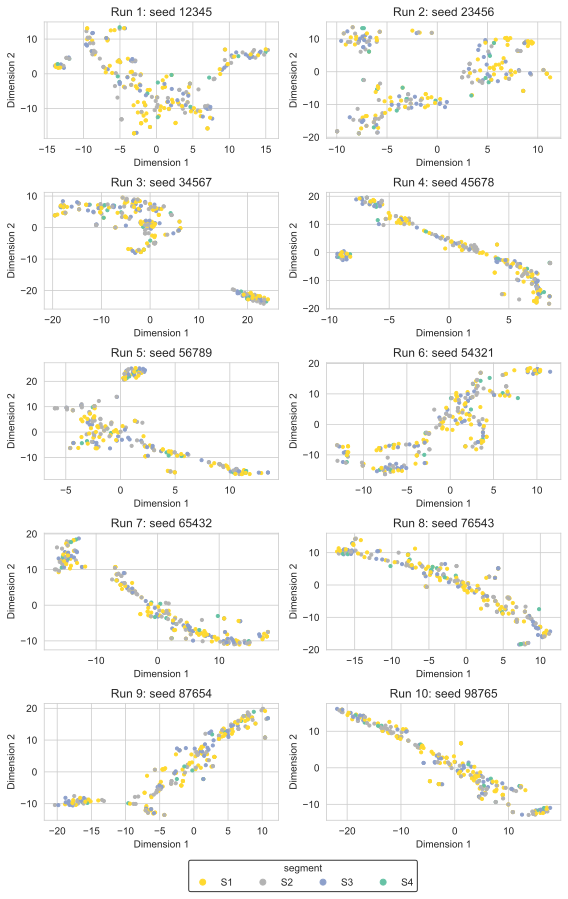

In [20]:
plot_embeddings(gat_embeddings, 'gat_scatterplots', True)

### Visualization of losses and accuracies

Finally, we take a look at the losses and accuracies in the training set, validation set and test set for the 10 runs for the best hyperparameter combination.

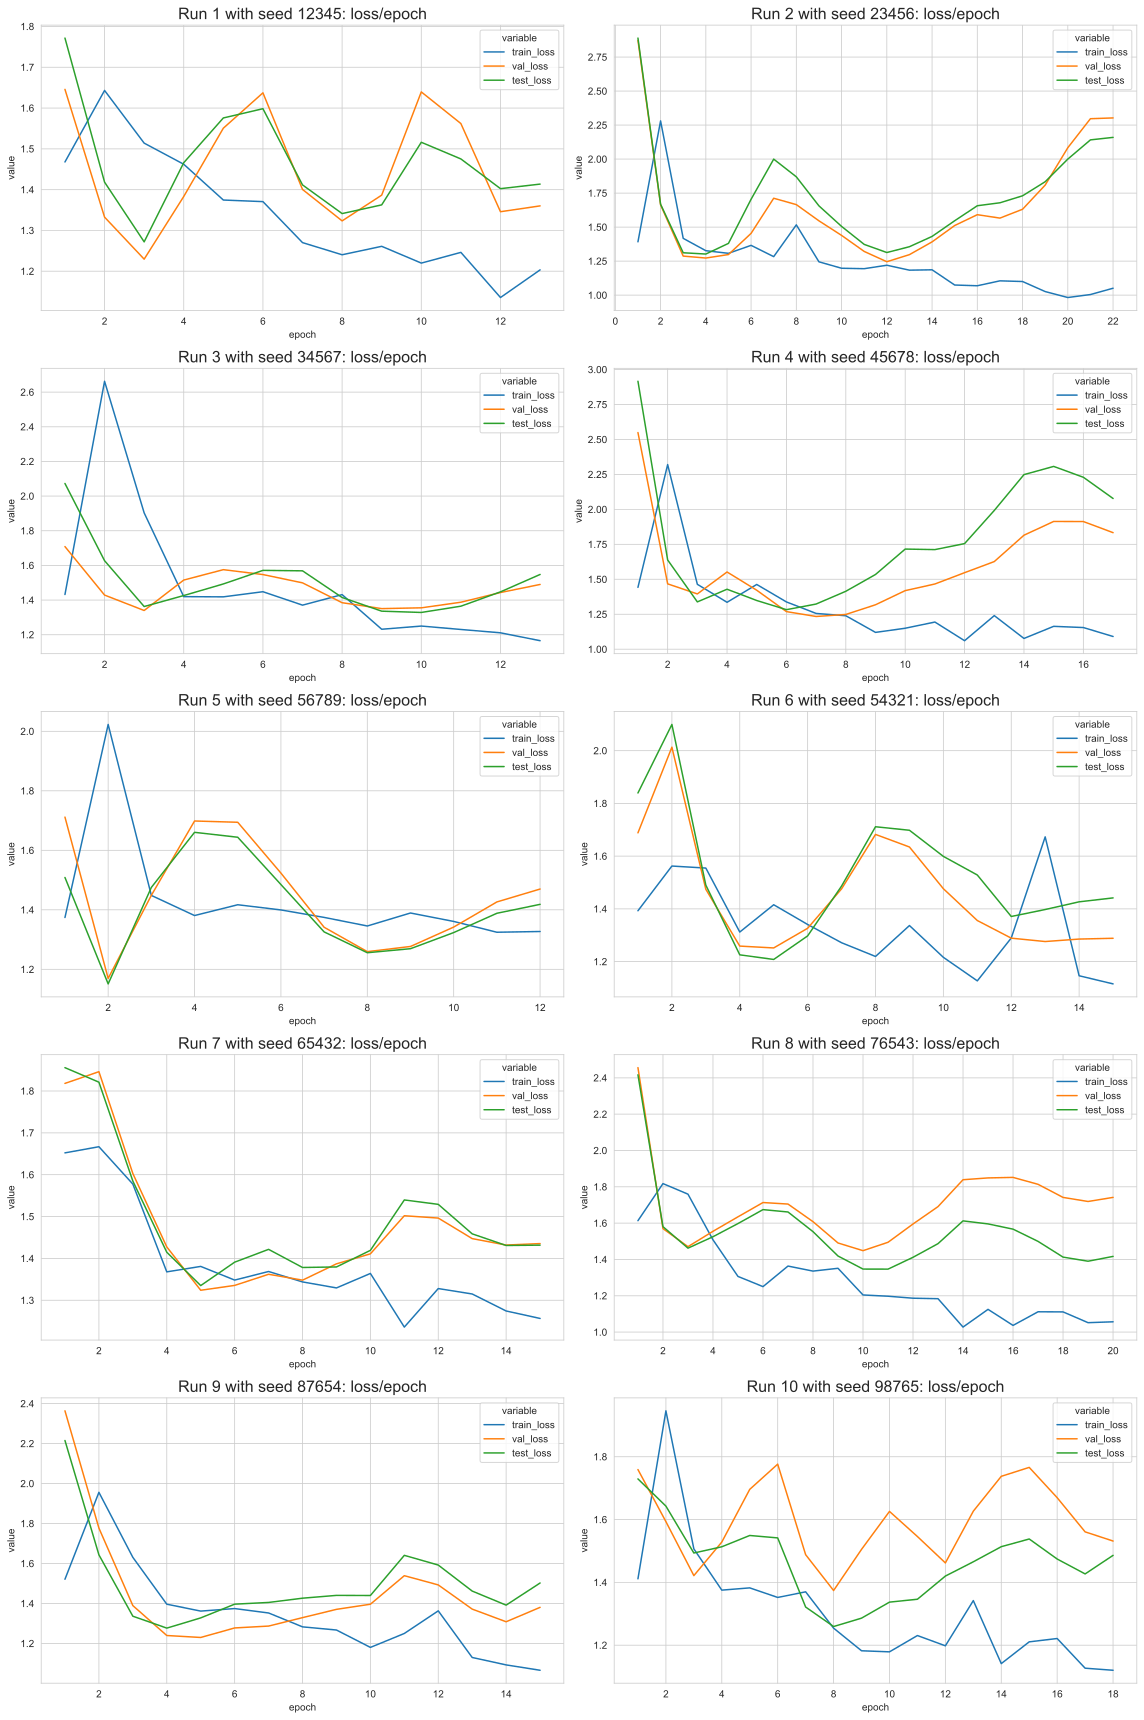

In [21]:
plot_losses_and_accuracies('loss', gat_results, 47, 2.0, 'gat_loss', True)

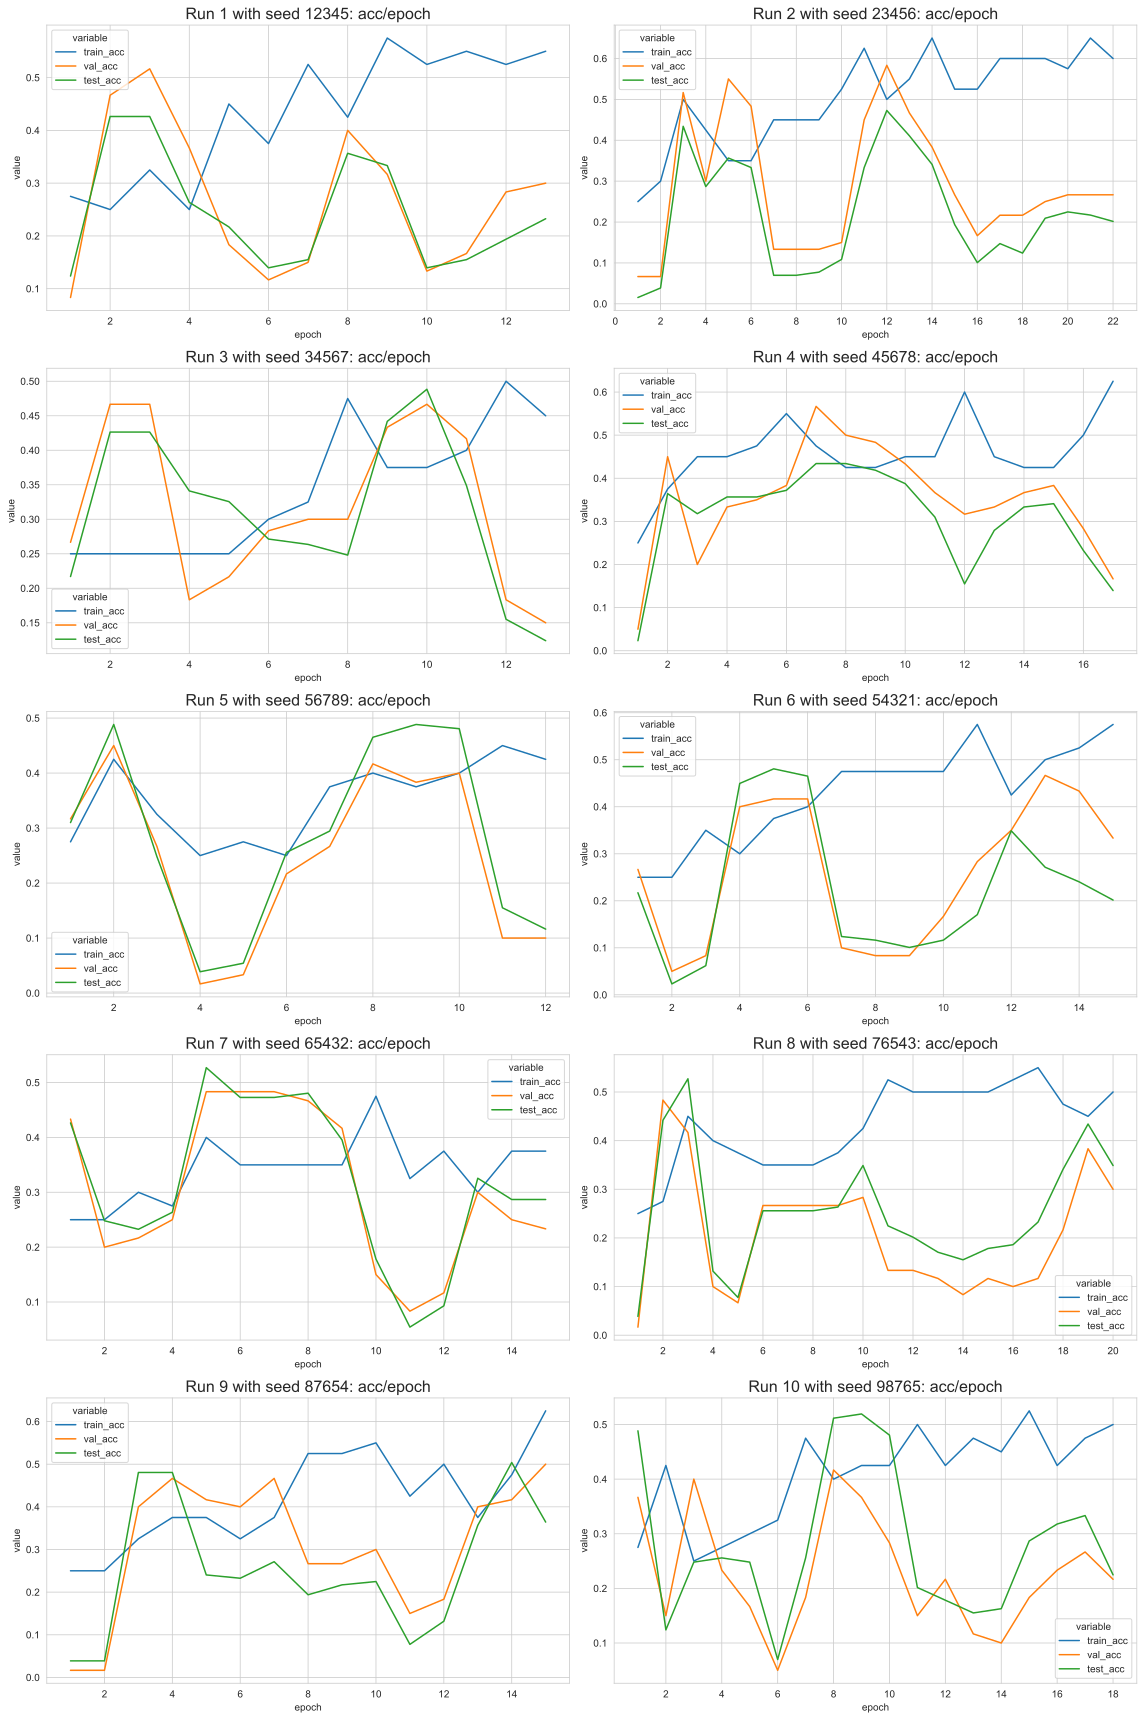

In [22]:
plot_losses_and_accuracies('acc', gat_results, 47, 2.0, 'gat_acc', True)